In [2]:
import torch
import torch.nn as nn

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from torchmetrics import Accuracy
from tqdm import tqdm

# GPU가 이용 가능한 경우 "cuda", 그렇지 않으면 "cpu"로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

print("operates on the {}".format(device))

operates on the cuda


In [3]:
# MLP Model
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),  # 입력 특성 784, 출력 특성 1024인 선형 레이어
            nn.ReLU(),  # ReLU 활성화 함수
            nn.Linear(1024, 512),  # 입력 특성 1024, 출력 특성 512인 선형 레이어
            nn.ReLU(),  # ReLU 활성화 함수
            nn.Linear(512, 512),  # 입력 특성 512, 출력 특성 512인 선형 레이어
            nn.ReLU(),  # ReLU 활성화 함수
            nn.Linear(512, 10),  # 입력 특성 512, 출력 특성 10인 선형 레이어
        )

    def forward(self, x):
        # 이미지를 일차원으로 펼침
        x = self.reshape(x)
        # MLP 모델에 입력 데이터를 전달하여 출력을 계산
        x = self.model(x)
        return x

In [4]:
def train(dataloader, model, loss_fn, optimizer, metric):
    # 데이터셋의 크기와 배치 크기 가져오기
    size = len(dataloader.dataset)
    batch_size = len(dataloader)
    
    # 손실과 정확도를 저장할 변수 초기화
    total_loss = 0
    acc_list = []
    
    # 모델을 학습 모드로 설정
    model.train()
    
    # 각 배치에 대해 학습 진행
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # GPU가 사용 가능한 경우 데이터를 GPU로 이동
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        
        # 모델에 입력 데이터 전달하여 예측값 계산
        y_pred = model(x)
        
        # 손실 계산
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        
        # 정확도 계산
        acc = metric(y_pred, y)
        acc_list.append(acc)
        
        # 그래디언트 초기화, 역전파, 최적화 수행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 배치 크기로 나누어 평균 손실과 정확도 계산
    total_loss /= batch_size
    total_acc = torch.tensor(acc_list).to(device).mean().item()
    
    # 학습 결과 반환
    return total_loss, total_acc

In [5]:
def train(dataloader, model, loss_fn, optimizer, metric):
    # 데이터셋의 크기와 배치 크기 가져오기
    size = len(dataloader.dataset)
    batch_size = len(dataloader)
    
    # 손실과 정확도를 저장할 변수 초기화
    total_loss = 0
    acc_list = []
    
    # 모델을 학습 모드로 설정
    model.train()
    
    # 각 배치에 대해 학습 진행
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # GPU가 사용 가능한 경우 데이터를 GPU로 이동
        if torch.cuda.is_available():
            x = x.to(device)
            y = y.to(device)
        
        # 모델에 입력 데이터 전달하여 예측값 계산
        y_pred = model(x)
        
        # 손실 계산
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        
        # 정확도 계산
        acc = metric(y_pred, y)
        acc_list.append(acc)
        
        # 그래디언트 초기화, 역전파, 최적화 수행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 배치 크기로 나누어 평균 손실과 정확도 계산
    total_loss /= batch_size
    total_acc = torch.tensor(acc_list).to(device).mean().item()
    
    # 학습 결과 반환
    return total_loss, total_acc

In [6]:
def validation(dataloader, model, loss_fn, metric):
    # 데이터셋의 크기와 배치 크기 가져오기
    size = len(dataloader.dataset)
    batch_size = len(dataloader)
    
    # 손실과 정확도를 저장할 변수 초기화
    total_loss = 0
    acc_list = []
    
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 그래디언트 계산을 비활성화한 상태에서 평가 진행
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            # GPU가 사용 가능한 경우 데이터를 GPU로 이동
            if torch.cuda.is_available():
                x = x.to(device)
                y = y.to(device)
            
            # 모델에 입력 데이터 전달하여 예측값 계산
            y_pred = model(x)
            
            # 손실 계산
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # 정확도 계산
            acc = metric(y_pred, y)
            acc_list.append(acc)
            
    # 배치 크기로 나누어 평균 손실과 정확도 계산
    total_loss /= batch_size
    total_acc = torch.tensor(acc_list).to(device).mean().item()
    
    # 평가 결과 반환
    return total_loss, total_acc


In [7]:
def test(dataloader, model, loss_fn, metric):
    # validation 함수를 이용하여 테스트 데이터에 대한 정확도 평가
    _, mean_acc = validation(dataloader, model, loss_fn, metric)
    
    # 평균 정확도 반환
    return mean_acc

In [8]:
# 데이터셋 불러오기

# MNIST 데이터셋의 학습 데이터를 불러와서 ToTensor() 변환을 적용하여 텐서로 변환
train_data = MNIST(root="data", train=True, transform=ToTensor(), download=True)

# MNIST 데이터셋의 학습 데이터를 불러와서 ToTensor() 변환을 적용하여 텐서로 변환
test_data = MNIST(root="data", train=False, transform=ToTensor(), download=True)

# 학습 데이터로 사용할 DataLoader 생성 (배치 크기: 256)
train_loader = DataLoader(train_data, batch_size=256)

# 테스트 데이터로 사용할 DataLoader 생성 (배치 크기: 256)
test_loader = DataLoader(test_data, batch_size=256)

In [9]:
# 모델 하이퍼 파라미터 정의

# SequentialModel 클래스를 이용하여 모델 초기화 및 GPU 사용 설정
model = SequentialModel().to(device)

# CrossEntropyLoss를 사용한 손실 함수 정의
loss_fn = nn.CrossEntropyLoss()

# Adam 옵티마이저를 사용하여 최적화 설정 (학습률: 0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Accuracy 메트릭을 사용하여 다중 클래스 분류 정확도 평가 (클래스 수: 10)
metric = Accuracy(task="multiclass", num_classes=10).to(device)

# 최대 학습 에폭 설정
max_epochs = 100

# 학습 과정에서 기록할 히스토리 변수 초기화
history = {
    "loss": [],          # 학습 손실 기록
    "accuracy": [],      # 학습 정확도 기록
    "val_loss": [],      # 검증 손실 기록
    "val_accuracy": [],  # 검증 정확도 기록
}

In [10]:
# Model 학습

# 최대 학습 에폭까지 루프 수행
for t in range(max_epochs):
    print(f"Epoch {t+1}")
    print("=" * 20)
    
    # 학습 함수를 호출하여 학습 진행하고 손실 및 정확도 기록
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, metric)
    
    # 검증 함수를 호출하여 테스트 데이터에 대한 손실 및 정확도 기록
    val_loss, val_acc = validation(test_loader, model, loss_fn, metric)
    
    # 검증 정확도 출력
    print("Validation Accuracy: {:.5f} %".format(val_acc * 100))
    
    # 학습 과정의 손실과 정확도를 history 딕셔너리에 기록
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

# 학습이 완료된 모델의 파라미터를 파일로 저장
torch.save(model.state_dict(), "MNIST.pth")

Epoch 1


100%|██████████| 40/40 [00:00<00:00, 43.46it/s]


Validation Accuracy: 91.07422 %
Epoch 2


100%|██████████| 40/40 [00:00<00:00, 40.70it/s]


Validation Accuracy: 93.42774 %
Epoch 3


100%|██████████| 40/40 [00:00<00:00, 42.73it/s]


Validation Accuracy: 94.55078 %
Epoch 4


100%|██████████| 40/40 [00:00<00:00, 40.85it/s]


Validation Accuracy: 95.61524 %
Epoch 5


100%|██████████| 40/40 [00:00<00:00, 43.61it/s]


Validation Accuracy: 96.14258 %
Epoch 6


100%|██████████| 40/40 [00:01<00:00, 38.88it/s]


Validation Accuracy: 96.44532 %
Epoch 7


100%|██████████| 40/40 [00:00<00:00, 42.17it/s]


Validation Accuracy: 96.69922 %
Epoch 8


100%|██████████| 40/40 [00:00<00:00, 41.56it/s]


Validation Accuracy: 97.01172 %
Epoch 9


100%|██████████| 40/40 [00:00<00:00, 41.19it/s]


Validation Accuracy: 97.26562 %
Epoch 10


100%|██████████| 40/40 [00:00<00:00, 40.39it/s]


Validation Accuracy: 97.47071 %
Epoch 11


100%|██████████| 40/40 [00:00<00:00, 40.34it/s]


Validation Accuracy: 97.53906 %
Epoch 12


100%|██████████| 40/40 [00:01<00:00, 37.34it/s]


Validation Accuracy: 97.55859 %
Epoch 13


100%|██████████| 40/40 [00:00<00:00, 40.82it/s]


Validation Accuracy: 97.59766 %
Epoch 14


100%|██████████| 40/40 [00:00<00:00, 43.17it/s]


Validation Accuracy: 97.64649 %
Epoch 15


100%|██████████| 40/40 [00:01<00:00, 39.59it/s]


Validation Accuracy: 97.73437 %
Epoch 16


100%|██████████| 40/40 [00:00<00:00, 43.88it/s]


Validation Accuracy: 97.73437 %
Epoch 17


100%|██████████| 40/40 [00:00<00:00, 42.43it/s]


Validation Accuracy: 97.80273 %
Epoch 18


100%|██████████| 40/40 [00:00<00:00, 43.65it/s]


Validation Accuracy: 97.83203 %
Epoch 19


100%|██████████| 40/40 [00:00<00:00, 41.47it/s]


Validation Accuracy: 97.86133 %
Epoch 20


100%|██████████| 40/40 [00:01<00:00, 35.42it/s]


Validation Accuracy: 97.80273 %
Epoch 21


100%|██████████| 40/40 [00:00<00:00, 42.69it/s]


Validation Accuracy: 97.78320 %
Epoch 22


100%|██████████| 40/40 [00:00<00:00, 40.05it/s]


Validation Accuracy: 97.79297 %
Epoch 23


100%|██████████| 40/40 [00:00<00:00, 40.65it/s]


Validation Accuracy: 97.88086 %
Epoch 24


100%|██████████| 40/40 [00:00<00:00, 44.10it/s]


Validation Accuracy: 97.95899 %
Epoch 25


100%|██████████| 40/40 [00:00<00:00, 43.90it/s]


Validation Accuracy: 97.94922 %
Epoch 26


100%|██████████| 40/40 [00:00<00:00, 43.95it/s]


Validation Accuracy: 97.89063 %
Epoch 27


100%|██████████| 40/40 [00:00<00:00, 44.11it/s]


Validation Accuracy: 97.89063 %
Epoch 28


100%|██████████| 40/40 [00:00<00:00, 43.20it/s]


Validation Accuracy: 97.87109 %
Epoch 29


100%|██████████| 40/40 [00:00<00:00, 40.62it/s]


Validation Accuracy: 97.64649 %
Epoch 30


100%|██████████| 40/40 [00:01<00:00, 39.42it/s]


Validation Accuracy: 97.84180 %
Epoch 31


100%|██████████| 40/40 [00:00<00:00, 43.32it/s]


Validation Accuracy: 97.41211 %
Epoch 32


100%|██████████| 40/40 [00:01<00:00, 38.53it/s]


Validation Accuracy: 97.97851 %
Epoch 33


100%|██████████| 40/40 [00:00<00:00, 40.88it/s]


Validation Accuracy: 98.05664 %
Epoch 34


100%|██████████| 40/40 [00:00<00:00, 41.79it/s]


Validation Accuracy: 98.16406 %
Epoch 35


100%|██████████| 40/40 [00:01<00:00, 38.91it/s]


Validation Accuracy: 98.23242 %
Epoch 36


100%|██████████| 40/40 [00:00<00:00, 41.40it/s]


Validation Accuracy: 98.28125 %
Epoch 37


100%|██████████| 40/40 [00:01<00:00, 38.07it/s]


Validation Accuracy: 98.01758 %
Epoch 38


100%|██████████| 40/40 [00:00<00:00, 40.75it/s]


Validation Accuracy: 98.13477 %
Epoch 39


100%|██████████| 40/40 [00:00<00:00, 43.43it/s]


Validation Accuracy: 98.21289 %
Epoch 40


100%|██████████| 40/40 [00:00<00:00, 40.91it/s]


Validation Accuracy: 98.17383 %
Epoch 41


100%|██████████| 40/40 [00:01<00:00, 38.76it/s]


Validation Accuracy: 98.17383 %
Epoch 42


100%|██████████| 40/40 [00:00<00:00, 43.70it/s]


Validation Accuracy: 98.19336 %
Epoch 43


100%|██████████| 40/40 [00:00<00:00, 40.71it/s]


Validation Accuracy: 98.19336 %
Epoch 44


100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Validation Accuracy: 98.18360 %
Epoch 45


100%|██████████| 40/40 [00:00<00:00, 41.11it/s]


Validation Accuracy: 98.18360 %
Epoch 46


100%|██████████| 40/40 [00:00<00:00, 41.02it/s]


Validation Accuracy: 98.19336 %
Epoch 47


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Validation Accuracy: 98.18360 %
Epoch 48


100%|██████████| 40/40 [00:00<00:00, 40.14it/s]


Validation Accuracy: 98.17383 %
Epoch 49


100%|██████████| 40/40 [00:01<00:00, 38.51it/s]


Validation Accuracy: 98.16406 %
Epoch 50


100%|██████████| 40/40 [00:00<00:00, 44.00it/s]


Validation Accuracy: 98.17383 %
Epoch 51


100%|██████████| 40/40 [00:00<00:00, 43.88it/s]


Validation Accuracy: 98.17383 %
Epoch 52


100%|██████████| 40/40 [00:00<00:00, 41.19it/s]


Validation Accuracy: 98.17383 %
Epoch 53


100%|██████████| 40/40 [00:01<00:00, 39.29it/s]


Validation Accuracy: 98.18360 %
Epoch 54


100%|██████████| 40/40 [00:01<00:00, 39.40it/s]


Validation Accuracy: 98.17383 %
Epoch 55


100%|██████████| 40/40 [00:01<00:00, 38.46it/s]


Validation Accuracy: 98.17383 %
Epoch 56


100%|██████████| 40/40 [00:00<00:00, 40.65it/s]


Validation Accuracy: 98.18360 %
Epoch 57


100%|██████████| 40/40 [00:01<00:00, 39.02it/s]


Validation Accuracy: 98.18360 %
Epoch 58


100%|██████████| 40/40 [00:00<00:00, 41.58it/s]


Validation Accuracy: 98.18360 %
Epoch 59


100%|██████████| 40/40 [00:00<00:00, 40.66it/s]


Validation Accuracy: 98.18360 %
Epoch 60


100%|██████████| 40/40 [00:00<00:00, 40.72it/s]


Validation Accuracy: 98.18360 %
Epoch 61


100%|██████████| 40/40 [00:00<00:00, 41.58it/s]


Validation Accuracy: 98.19336 %
Epoch 62


100%|██████████| 40/40 [00:00<00:00, 42.19it/s]


Validation Accuracy: 98.18360 %
Epoch 63


100%|██████████| 40/40 [00:00<00:00, 43.62it/s]


Validation Accuracy: 98.20313 %
Epoch 64


100%|██████████| 40/40 [00:00<00:00, 40.58it/s]


Validation Accuracy: 98.20313 %
Epoch 65


100%|██████████| 40/40 [00:00<00:00, 44.91it/s]


Validation Accuracy: 98.20313 %
Epoch 66


100%|██████████| 40/40 [00:01<00:00, 37.77it/s]


Validation Accuracy: 98.20313 %
Epoch 67


100%|██████████| 40/40 [00:00<00:00, 40.96it/s]


Validation Accuracy: 98.18360 %
Epoch 68


100%|██████████| 40/40 [00:01<00:00, 35.23it/s]


Validation Accuracy: 98.19336 %
Epoch 69


100%|██████████| 40/40 [00:00<00:00, 40.81it/s]


Validation Accuracy: 98.19336 %
Epoch 70


100%|██████████| 40/40 [00:01<00:00, 39.62it/s]


Validation Accuracy: 98.19336 %
Epoch 71


100%|██████████| 40/40 [00:00<00:00, 43.13it/s]


Validation Accuracy: 98.19336 %
Epoch 72


100%|██████████| 40/40 [00:01<00:00, 39.71it/s]


Validation Accuracy: 98.19336 %
Epoch 73


100%|██████████| 40/40 [00:00<00:00, 41.16it/s]


Validation Accuracy: 98.21289 %
Epoch 74


100%|██████████| 40/40 [00:00<00:00, 41.25it/s]


Validation Accuracy: 98.22266 %
Epoch 75


100%|██████████| 40/40 [00:00<00:00, 43.66it/s]


Validation Accuracy: 98.22266 %
Epoch 76


100%|██████████| 40/40 [00:00<00:00, 40.04it/s]


Validation Accuracy: 98.22266 %
Epoch 77


100%|██████████| 40/40 [00:00<00:00, 42.27it/s]


Validation Accuracy: 98.22266 %
Epoch 78


100%|██████████| 40/40 [00:01<00:00, 38.62it/s]


Validation Accuracy: 98.23242 %
Epoch 79


100%|██████████| 40/40 [00:00<00:00, 41.00it/s]


Validation Accuracy: 98.22266 %
Epoch 80


100%|██████████| 40/40 [00:01<00:00, 39.94it/s]


Validation Accuracy: 98.22266 %
Epoch 81


100%|██████████| 40/40 [00:00<00:00, 40.71it/s]


Validation Accuracy: 98.22266 %
Epoch 82


100%|██████████| 40/40 [00:01<00:00, 39.38it/s]


Validation Accuracy: 98.22266 %
Epoch 83


100%|██████████| 40/40 [00:01<00:00, 39.58it/s]


Validation Accuracy: 98.22266 %
Epoch 84


100%|██████████| 40/40 [00:00<00:00, 44.01it/s]


Validation Accuracy: 98.22266 %
Epoch 85


100%|██████████| 40/40 [00:00<00:00, 40.40it/s]


Validation Accuracy: 98.22266 %
Epoch 86


100%|██████████| 40/40 [00:01<00:00, 38.36it/s]


Validation Accuracy: 98.23242 %
Epoch 87


100%|██████████| 40/40 [00:01<00:00, 37.94it/s]


Validation Accuracy: 98.24219 %
Epoch 88


100%|██████████| 40/40 [00:00<00:00, 43.34it/s]


Validation Accuracy: 98.24219 %
Epoch 89


100%|██████████| 40/40 [00:01<00:00, 38.75it/s]


Validation Accuracy: 98.24219 %
Epoch 90


100%|██████████| 40/40 [00:00<00:00, 40.40it/s]


Validation Accuracy: 98.24219 %
Epoch 91


100%|██████████| 40/40 [00:00<00:00, 41.73it/s]


Validation Accuracy: 98.24219 %
Epoch 92


100%|██████████| 40/40 [00:01<00:00, 39.13it/s]


Validation Accuracy: 98.25196 %
Epoch 93


100%|██████████| 40/40 [00:00<00:00, 40.30it/s]


Validation Accuracy: 98.25196 %
Epoch 94


100%|██████████| 40/40 [00:00<00:00, 42.63it/s]


Validation Accuracy: 98.25196 %
Epoch 95


100%|██████████| 40/40 [00:01<00:00, 37.98it/s]


Validation Accuracy: 98.25196 %
Epoch 96


100%|██████████| 40/40 [00:00<00:00, 44.50it/s]


Validation Accuracy: 98.25196 %
Epoch 97


100%|██████████| 40/40 [00:01<00:00, 37.83it/s]


Validation Accuracy: 98.25196 %
Epoch 98


100%|██████████| 40/40 [00:00<00:00, 43.30it/s]


Validation Accuracy: 98.25196 %
Epoch 99


100%|██████████| 40/40 [00:00<00:00, 43.05it/s]


Validation Accuracy: 98.25196 %
Epoch 100


100%|██████████| 40/40 [00:00<00:00, 42.80it/s]

Validation Accuracy: 98.25196 %


100%|██████████| 40/40 [00:01<00:00, 38.25it/s]


Accuracy: 98.25196 %


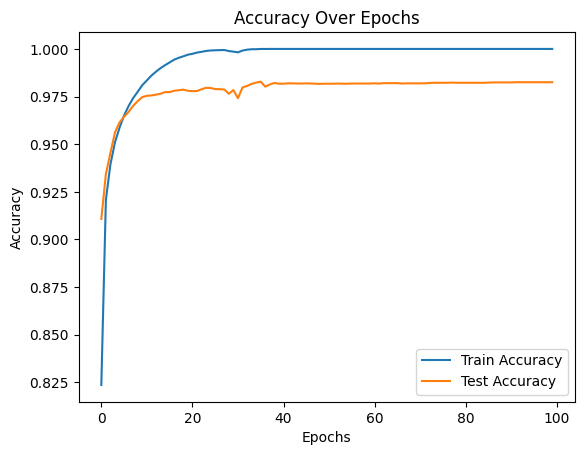

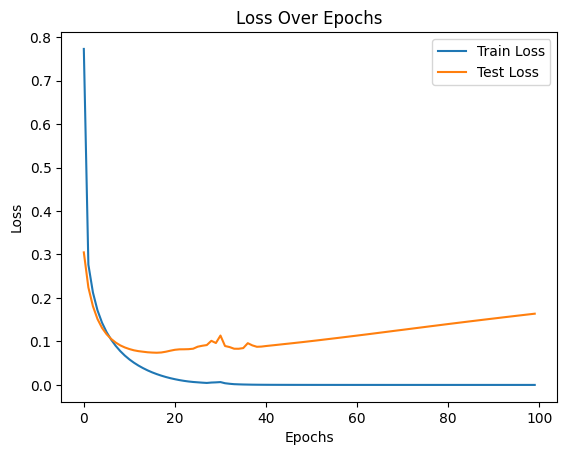

In [11]:
# 미리 학습된 모델 불러오기
model = SequentialModel().to(device)
model.load_state_dict(torch.load("MNIST.pth"))

# 테스트 데이터에 대한 정확도 평가
test_accuracy = test(test_loader, model, loss_fn, metric)
print("Accuracy: {:.5f} %".format(test_accuracy * 100))

# 정확도 그래프 출력
plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Test Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 손실 그래프 출력
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Test Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()